Goal: Function that generates a qubo for k-coloring on arbitrary graph G:
Source: https://arxiv.org/ftp/arxiv/papers/1811/1811.11538.pdf

In [68]:
from collections import defaultdict
from itertools import combinations 
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx
from dwave.system import LeapHybridSampler
import random
from networkx.generators.random_graphs import connected_watts_strogatz_graph as small_world 

In [30]:
def k_color_qubo(G, k, P=4):
    """
    Generate a QUBO instance Q representing k-coloring on G with penalty factor P
    QUBO generated in upper triangular form - equivalent to symmetric form (see link above pg4)
    """
    num_nodes = G.number_of_nodes()
    Q = defaultdict(int)
    
    # each node has 1 color constraints
    for node in range(num_nodes):
        for color in range(k):
            x = k * node + color
            Q[(x,x)] += - P
        for color1, color2 in combinations(range(k), 2):
            x1 = k * node + color1
            x2 = k * node + color2
            Q[(x1,x2)] += 2 * P  
    
    # adjacent nodes have diffent colors constraints
    for u, v in G.edges:
        for color in range(k):
            x1 = k * u + color
            x2 = k * v + color
            Q[(x1,x2)] += P
    
    
    return Q
    

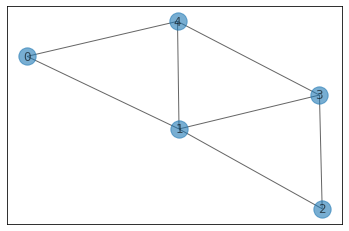

In [33]:
# from page 22 of https://arxiv.org/ftp/arxiv/papers/1811/1811.11538.pdf
# Here we 0-index instead of 1-indexing in the paper
test_graph = nx.empty_graph()
test_graph.add_nodes_from([0,1,2,3,4])
test_graph.add_edges_from([(0,1),(0,4),(1,2),(1,3),(1,4),(2,3),(3,4) ])
nx.draw_networkx(test_graph, node_labels = 300, alpha = .6)

In [37]:
test_3_color_qubo = k_color_qubo(test_graph,3)
test_3_color_qubo # looks like the paper!

defaultdict(int,
            {(0, 0): -4,
             (1, 1): -4,
             (2, 2): -4,
             (0, 1): 8,
             (0, 2): 8,
             (1, 2): 8,
             (3, 3): -4,
             (4, 4): -4,
             (5, 5): -4,
             (3, 4): 8,
             (3, 5): 8,
             (4, 5): 8,
             (6, 6): -4,
             (7, 7): -4,
             (8, 8): -4,
             (6, 7): 8,
             (6, 8): 8,
             (7, 8): 8,
             (9, 9): -4,
             (10, 10): -4,
             (11, 11): -4,
             (9, 10): 8,
             (9, 11): 8,
             (10, 11): 8,
             (12, 12): -4,
             (13, 13): -4,
             (14, 14): -4,
             (12, 13): 8,
             (12, 14): 8,
             (13, 14): 8,
             (0, 3): 4,
             (1, 4): 4,
             (2, 5): 4,
             (0, 12): 4,
             (1, 13): 4,
             (2, 14): 4,
             (3, 6): 4,
             (4, 7): 4,
             (5, 8): 4,
         

In [35]:
def solve(Q, chainstrength=8, numruns=100):
    """
    Solve a QUBO Q on a D-Wave hybrid machine 
    """
    sampler = LeapHybridSampler()
    response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
    energies = iter(response.data())
    return response.first

In [60]:
def convert_sample_to_subgraphs(G, sample, k):
    values = list(sample.sample.values())
    nodes_grouped_by_color = [[] for _ in range(k)]
    for node in range(G.number_of_nodes()):
        for color, group in zip(range(k), nodes_grouped_by_color):
            x = k * node + color
            if values[x] > .5: # true if and only if x=1 but x is sometimes outputed as float 1.0
                group.append(node)
    subgraphs_grouped_by_color = [nx.Graph.subgraph(G, nodes) for nodes in nodes_grouped_by_color]
    return subgraphs_grouped_by_color

In [65]:
def plot_colorized_groups(G, groups):
    """
    Visualize binary split by assigning a random color to each quarantine group in G
    """
    def n_random_colors(n):
        colors = []
        for i in range(n):
            colors.append('#%06X' % random.randint(0, 0xFFFFFF))
        return colors

    node_colors = [None for i in G.nodes]
    palette = n_random_colors(len(groups))
    for graph, color in zip(groups, palette):
        for node in graph.nodes:
            node_colors[node] = color

    pos = nx.spring_layout(G)
    fig = plt.figure(figsize=(6,6))
    default_axes = fig.add_subplot(frameon=True)
    nx.draw_networkx(G, node_size=400, alpha=1, node_color=node_colors)
    default_axes.set_title("")
    plt.show()

In [39]:
test_3_coloring = solve(test_3_color_qubo)

In [46]:
test_3_coloring
print(i for i in (test_3_coloring.sample.values()))

<generator object <genexpr> at 0x000001629D7CDF90>


In [63]:
test_3_grouped = convert_sample_to_subgraphs(test_graph, test_3_coloring, 3 )

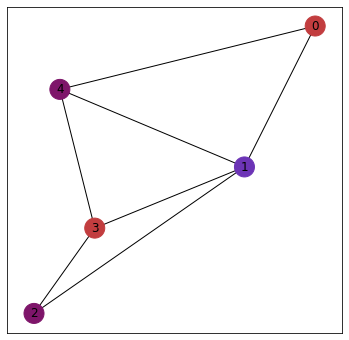

In [67]:
plot_colorized_groups(test_graph, test_3_grouped)

success!

Now lets scale up rather quickly to our full 3.8k node small network graph and see if it works to split into 4 colors on a hybrid solver

In [73]:
#cornell_approx = small_world(3800, 152, .15) # parameters explained in "Testing Networkx Graph Generators"
#cornell_approx_qubo = k_color_qubo(cornell_approx, 4)
#cornell_approx_solution = solve(cornell_approx_qubo)

small_cornell_approx = small_world(1600, 64, .15) # parameters explained in "Testing Networx Graph Generators"
small_cornell_approx_qubo = k_color_qubo(small_cornell_approx, 4)
small_cornell_approx_solution = solve(small_cornell_approx_qubo)